In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Sentiment Analysis Using RNN
## Steps:

### 1.Importing (or installing) tensorflow and other packages on your system
### 2.Loading your data from disk
### 3.Data Preprocessing and visualization
### 4.Creating your training and testing splits
### 5.Defining & Compiling your RNN model architecture
### 6.Training your model on your training data
### 7.Evaluating your model on your test data
### 8.Making predictions for unseen data

In [ ]:
# !pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 17kB/s 
     |████████████████████████████████| 3.9MB 51.4MB/s 
     |████████████████████████████████| 450kB 24.0MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=9e4d636cd1399264c632e900f634001633e66374650d29e56f518f7f47da3480
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.13.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully 

In [2]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [3]:
# import libraries
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
from tensorflow.keras.layers import Dense,SimpleRNN
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Flatten,Embedding
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization  
import tensorflow as tf
import itertools

import seaborn as sns
sns.set()

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
print("Tensorflow Version: {}".format(tf.__version__))

Tensorflow Version: 2.5.0


## 2. Load the Data from the disk

In [6]:
df = pd.read_csv("/content/drive/MyDrive/Colab/datasets/DL_paper2/tweets_train.csv")
df1 = pd.read_csv("/content/drive/MyDrive/Colab/datasets/DL_paper2/tweets_test.csv")


In [7]:
df_train = df.copy()
df_test = df1.copy()

In [8]:
df_train.head()

,clean_text,Sentiment
0,TheSocialDilemma is an eye opener isn t it ple...,Neutral
1,TheSocialDilemma If we don t agree on what is ...,Positive
2,Watching TheSocialDilemma scary to see social ...,Negative
3,You check your social media before you pee in ...,Positive
4,watch thesocialdilemma and see what s actually...,Negative


In [9]:
df_train = df_train.loc[:,['clean_text','Sentiment']]

In [10]:
df_train

,clean_text,Sentiment
0,TheSocialDilemma is an eye opener isn t it ple...,Neutral
1,TheSocialDilemma If we don t agree on what is ...,Positive
2,Watching TheSocialDilemma scary to see social ...,Negative
3,You check your social media before you pee in ...,Positive
4,watch thesocialdilemma and see what s actually...,Negative
...,...,...
9995,TheSocialDilemma on Well presented,Neutral
9996,TheSocialDilemma is track stopping documentary...,Positive
9997,After watching TheSocialDilemma on I m more aw...,Positive
9998,TheSocialDilemma put the end sequence at the b...,Negative


## 2.Data Preprocessing and Visulizations
###   1.Create tensor dataset for training & Batches for tensors
###   2.Convert tensors of string into sequence of number using   TextVectorization


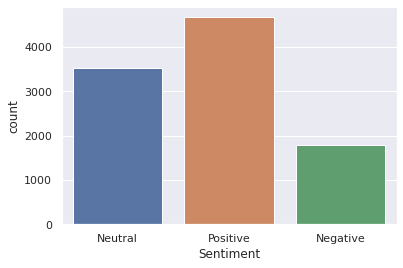

In [11]:
import seaborn as sns
sns.countplot(df_train["Sentiment"])

In [12]:
df_train["Sentiment"].value_counts()


Positive    4676
Neutral     3525
Negative    1799
Name: Sentiment, dtype: int64

In [13]:
Neg = round(df_train["Sentiment"].value_counts()[2]/len(df_train) * 100, 2)
Neu = round(df_train["Sentiment"].value_counts()[1]/len(df_train) * 100, 2)
Pos = round(df_train["Sentiment"].value_counts()[0]/len(df_train) * 100, 2)


print('This train_dataset contain {}% Negative Sentiment tweet'.format(Neg))
print('This train_dataset contain {}% Neutral Sentiment tweet'.format(Neu))
print('This train_dataset contain {}% Positive Sentiment tweet'.format(Pos))

This train_dataset contain 17.99% Negative Sentiment tweet
This train_dataset contain 35.25% Neutral Sentiment tweet
This train_dataset contain 46.76% Positive Sentiment tweet


In [14]:
# create a label columns using manual label encoding
lab = {"Positive":1,"Negative":0,'Neutral':2}
df_train['label']= df_train["Sentiment"].map(lab)
df_train.head()

,clean_text,Sentiment,label
0,TheSocialDilemma is an eye opener isn t it ple...,Neutral,2
1,TheSocialDilemma If we don t agree on what is ...,Positive,1
2,Watching TheSocialDilemma scary to see social ...,Negative,0
3,You check your social media before you pee in ...,Positive,1
4,watch thesocialdilemma and see what s actually...,Negative,0


In [15]:
def clean_review(text): 
    ''' 
    Utility function to clean review text by removing links, special characters 
    using simple regex statements. 
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split()).lower()

# clean tweet 
df_train["clean_review"] = df_train["clean_text"].apply(lambda text : clean_review(str(text)))

In [16]:
df_train.head()

,clean_text,Sentiment,label,clean_review
0,TheSocialDilemma is an eye opener isn t it ple...,Neutral,2,thesocialdilemma is an eye opener isn t it ple...
1,TheSocialDilemma If we don t agree on what is ...,Positive,1,thesocialdilemma if we don t agree on what is ...
2,Watching TheSocialDilemma scary to see social ...,Negative,0,watching thesocialdilemma scary to see social ...
3,You check your social media before you pee in ...,Positive,1,you check your social media before you pee in ...
4,watch thesocialdilemma and see what s actually...,Negative,0,watch thesocialdilemma and see what s actually...


In [17]:
df_train = df_train[["clean_review", "label"]]

In [18]:
# drop missing rows
# df_train = df_train.dropna()
df_train.isnull().sum()

clean_review    0
label           0
dtype: int64

In [19]:
# convert training dataset into tensorflow dataset format

train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(df_train["clean_review"].values, tf.string),
            tf.cast(df_train['label'].values, tf.int32)
        )
    )
)



In [20]:
# convert tensorflow dataset into 64 batches format
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [21]:
train_dataset

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>

In [22]:
for example, label in train_dataset.take(1):
    print("example : ", example.numpy())
    print("-----------------------")
    print("label: ", label.numpy())
    print("-----------------------")
    print("total len: ", len(label.numpy()))

example :  [b'free your mind thesocialdilemma and what you can do about it'
 b'everyone should watch this movie who are addicted to social media we all are thesocialdilemma'
 b'it was the makers thesocialdilemma to post this film on net amp then it was mine to watch it on that amp its even more'
 b'i did stumble upon this film after strategically sifting through films thesocialdilemma and damn we are pons for r'
 b'nice meaningful dialogue thesocialdilemma try educating yourself'
 b'i just started watching thesocialdilemma and i m already terrified after the first 4 minutes'
 b'because you are the product thesocialdilemma'
 b'thesocialdilemma will shock you only if you haven t paying attention to what s happening in the world thanks to'
 b'thesocialdilemma a must watch'
 b'there are only two industries that call their customers users illegal drugs and software'
 b'thesocialdilemma on netflix is definitely worth a watch'
 b'thesocialdilemma on is absolutely brilliant piece thanks for br

## 3.Train-Test Split on Train Data

In [23]:
val_dataset = train_dataset.take(100)
train_dataset = train_dataset.skip(100)


### TextVectorization: Convert Batches of tensor string into Sequence of data in numeric form

In [24]:
VOCAB_SIZE = 1000
encoder = TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [25]:
vocab = np.array(encoder.get_vocabulary())

In [26]:
len(encoder.get_vocabulary())

1000

In [27]:
vocab[22]

'are'

In [28]:
len(vocab)

1000

In [29]:
t = encoder("This is nice pen! my name is dev")
t

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([ 17,  10, 668,   1,  29, 954,  10,   1])>

In [30]:
encoder.get_vocabulary()[337]

'fascinating'

In [31]:
# create RNN model
model = tf.keras.Sequential([
    encoder,
    Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True), # word2vec
    SimpleRNN(64),
    Dense(64, activation="relu"),
    Dense(1) # tf.keras.layers.Dense(3, activation="softmax")
])

In [32]:
sample_text = ("the movie was not cool. the animatioin and the graphics werer not out of this world. i would not recommend this movie")

predictions = model.predict_classes(np.array([sample_text]))[0][0]
print(predictions)

0


# exeperimental model to learn each layers of models how it works in steps


In [33]:

tf.keras.losses.BinaryCrossentropy?

In [34]:
model2 = tf.keras.Sequential([
    encoder, #convert words into sequnce of number
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=5, mask_zero=True), # create vectors of each words in o/p dim here 4 words so create 4 vector-->5 dim
    tf.keras.layers.SimpleRNN(32), # RNN model using o/p dim
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(5))
    tf.keras.layers.Dense(5, activation="relu"), # dense layer
    tf.keras.layers.Dense(1)
])

sample_text = ("the movie was cool")
predictions = model2.predict(np.array([sample_text]))
print(predictions)

[[-0.00051671]]


In [35]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                8256      
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 76,481
Trainable params: 76,481
Non-trainable params: 0
_________________________________________________________________


In [37]:
EPOCHS = 10

results =model.fit(train_dataset,
                  epochs=EPOCHS,
                  validation_data=val_dataset)

Epoch 1/10
57/57 [==============================] - 4s 49ms/step - loss: 0.5953 - accuracy: 0.1953 - val_loss: 0.3951 - val_accuracy: 0.3992
Epoch 2/10
57/57 [==============================] - 3s 44ms/step - loss: -0.0462 - accuracy: 0.4439 - val_loss: -0.3525 - val_accuracy: 0.4669
Epoch 3/10
57/57 [==============================] - 3s 45ms/step - loss: -0.4543 - accuracy: 0.4678 - val_loss: -0.7994 - val_accuracy: 0.4695
Epoch 4/10
57/57 [==============================] - 3s 44ms/step - loss: -1.1685 - accuracy: 0.4664 - val_loss: -1.3602 - val_accuracy: 0.4697
Epoch 5/10
57/57 [==============================] - 3s 49ms/step - loss: -1.6379 - accuracy: 0.4558 - val_loss: -1.9505 - val_accuracy: 0.4663
Epoch 6/10
57/57 [==============================] - 3s 49ms/step - loss: -2.3760 - accuracy: 0.4689 - val_loss: -2.5537 - val_accuracy: 0.4684
Epoch 7/10
57/57 [==============================] - 3s 47ms/step - loss: -2.7832 - accuracy: 0.4728 - val_loss: -3.3671 - val_accuracy: 0.4708
E

In [38]:
text = 'it is a bad movie not recommending to other it has only ratings of 2 on imdb'
predictions = model.predict_classes(np.array([text]))[0][0]
print(predictions)

1


In [39]:
test_loss, test_acc = model.evaluate(val_dataset)

100/100 [==============================] - 1s 5ms/step - loss: -5.2677 - accuracy: 0.4633


In [40]:
print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_acc))

Test Loss: -5.267670154571533
Test Accuracy: 0.4632812440395355


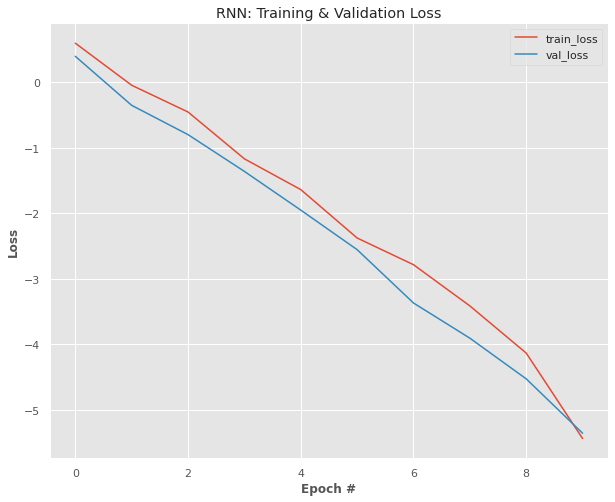

In [41]:
# plot the training and validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, results.history["loss"], label="train_loss")
plt.plot(N, results.history["val_loss"], label="val_loss")
plt.title("RNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

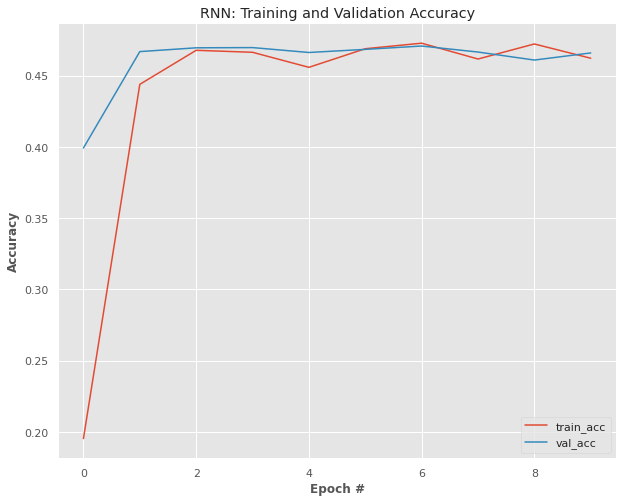

In [42]:
# plot the training and validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, results.history["accuracy"], label="train_acc")
plt.plot(N, results.history["val_accuracy"], label="val_acc")
plt.title("RNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

In [43]:
# predict on a sample text 

sample_text = ("i love twitting about politics and environment")

prediction = model.predict_classes(np.array([sample_text]))
print(prediction)

# if prediction[0][0] >= 0:
#     print("positive")
# else:
#     print("negative")

[[1]]


In [44]:
model

In [ ]:
model.save?


In [50]:
# save the model to disk
print("[INFO] serializing network...")
model.save_weights("/content/drive/MyDrive/Colab/datasets/models",'RNN.h5')

[INFO] serializing network...


In [48]:
from tensorflow.keras.models import load_model
new_model = load_model("/content/drive/MyDrive/Colab/datasets/models/RNN")
print("[INFO] model loaded succesfully..")

[INFO] model loaded succesfully..


In [ ]:
y_pred = model.predict(np.array(df_test["clean_text"]))

ValueError: ignored

In [ ]:
for i in df_test['clean_text']:
  y = new_model.predict_classes(np.array([i]))[0][0]
  print(y)
  

Streaming output truncated to the last 5000 lines.
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

UnimplementedError: ignored